# SPE GCS ML Challenge 2021
By: Doa Ibu Team
- Raden Sasangka Ardi Nugraha 
- Mordekhai
- Luthfi Nurul Hidayah Saifudin
- Alfian Rahman

In [1]:
# Install dependencies
!pip install -r requirements.txt --user --quiet

In [2]:
import json
import gc
import lasio 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import zipfile
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

#Expand data range display
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Data Preprocessing

In [3]:
def LoadData(filename):
    l = lasio.read(filename)
    data_well = l.df()
    log = list(data_well.columns.values)
    header =[{'WELL': filename, 
            'START':l.well.STRT.value,
            'STOP':l.well.STOP.value,
            'STEP':l.well.STEP.value,
            'LAT':l.well.SLAT.value,
            'LON':l.well.SLON.value,
            'DATUM':l.well.DATUM.value}]
    data_well['WELL'] = filename  

    log_list = pd.DataFrame(header)
    for newlog in log:
        log_list[newlog]= "v"
    return data_well, log_list

def MergeAlias(db, alias, logs_selected):
    well = db['WELL'].unique()
    merged_data = pd.DataFrame()

    for i in range(len(well)):
        data = db.where(db['WELL']==well[i]).dropna(axis=1, how='all')
        for j in range(len(alias)):
            welllog_name = list(set(data.columns).intersection(alias.get(list(alias)[j])))
            samelog = data[welllog_name]
            count_log = dict(sorted(zip(welllog_name, samelog.count()), key=lambda item: item[1], reverse=True))
            welllog_name = list(count_log.keys())
            if (len(welllog_name)!=0):
                #If more than one log aliases exist, normalize each log to have same data range in the same depth
                if (len(welllog_name)>1):
                    alias_logs = data[welllog_name].dropna()
                if (list(alias)[j] not in ['CAL','DTCO','DTSM']) and (len(alias_logs)!=0):
                    a = []; b = []; c = []
                    for n in range(len(alias_logs.columns)):
                        q1 = alias_logs[welllog_name[n]].quantile(0.1)
                        q9 = alias_logs[welllog_name[n]].quantile(0.9)
                        a.append(q1)
                        b.append(q9)
                        c = [b-a for (a,b) in zip(a,b)]
                        c = list(map(lambda x: x/c[0],c))
                    for n in range(len(welllog_name)):
                        data.loc[:, welllog_name[n]] *= 1/c[n]
                for k in range(len(welllog_name)-1):
                    data[welllog_name[0]].fillna(data[welllog_name[k+1]], inplace=True)
                data[list(alias)[j]] = data[welllog_name[0]]
        merged_data = merged_data.append(data)
        merged_data = merged_data[merged_data['WELL'].notna()]
    merged_data = merged_data[logs_selected]
    return merged_data

In [4]:
##============================================================================
# train_source_dir: folder containing LAS files for train dataset
# test_source_dir: folder containing LAS files for test dataset
# alias_file: dictionaries of log alias in JSON format (key:main log name, value:list of log alias/es)
# logs_selected: list of log willing to be included in train and test dataset
#
# WARNING: Data loading and merging consumes a lot of memory. Unless you are running on a high computing device, 
# it is recommended to run the process in batch of 20-30 LAS files, then merge the result together.
##============================================================================

# UNCOMMENT THE CODES BELOW IF YOU WANT TO DO THE PROCESSING STEPS (IT MAY TAKE MINUTES OR HOURS) 

# #Initialization
# current_dir = os.getcwd()
# train_source_dir = '/data/train'
# test_source_dir = '/data/test'
# alias_file = '/data/alias.json'
# logs_selected= ['WELL','DEPT','CAL','SP','GR','POR','DRES','DTCO','PEF','DENS','DRHO']

# with open(current_dir + alias_file, 'r') as file:
#     alias = json.load(file)

# # Loading raw data for train dataset
# data_train = pd.DataFrame()
# log_ava_train = pd.DataFrame()
# for f in sorted(os.listdir(train_source_dir)):
#     data_well, log_list = LoadData(f"/{train_source_dir}/{f}")
#     data_train = data_train.append(data_well)
#     log_ava_train = log_ava_train.append(log_list)

# # Merge log aliases for train dataset
# data_train = data_train.reset_index()
# train = MergeAlias(data_train,alias,logs_selected).dropna()
# train.rename(columns={'POR':'NPHI','DENS':'RHOB'}, inplace=True)

# # Select well data which has more than 5000ft length
# log_ava_train['LENGTH'] = log_ava_train['STOP']-log_ava_train['START']
# log_ava_train = log_ava_train.sort_values('LENGTH', ascending=False)
# well_selected = log_ava_train[log_ava_train['LENGTH']>10000]
# well_selected = well_selected['WELL']

# train = train[train['WELL'].isin(well_selected)]

# # Loading raw data for test dataset
# data_test = pd.DataFrame()
# log_ava_test = pd.DataFrame()
# for f in sorted(os.listdir(current_dir + test_source_dir)):
#     data_well, log_list = LoadData(current_dir + f"/{test_source_dir}/{f}")
#     data_test = data_test.append(data_well)
#     log_ava_test = log_ava_test.append(log_list)

# # Merge log aliases for test dataset
# data_test = data_test.reset_index()
# test = MergeAlias(data_test, alias, logs_selected)
# test.rename(columns={'POR':'NPHI','DENS':'RHOB'}, inplace=True)

# # Save loaded data
# train.to_csv('data/preprocessed/train.csv')
# test.to_csv('data/preprocessed/test.csv')

# #Display raw data distribution
# log_ava_train.count().plot(kind='bar', figsize=(35,7), title='Train Raw Data')
# log_ava_test.count().plot(kind='bar', figsize=(35,7), title='Test Raw Data')

# #Display data distribution - after merging aliases
# train.count().plot(kind='bar', figsize=(35,7), title='Test Data')
# test.count().plot(kind='bar', figsize=(35,7), title='Test Data')

In [5]:
## Code from Bang Dekha & Kak Upi (for test data)

In [6]:
df = pd.read_csv('data/preprocessed/train.csv')

## Data Cleansing

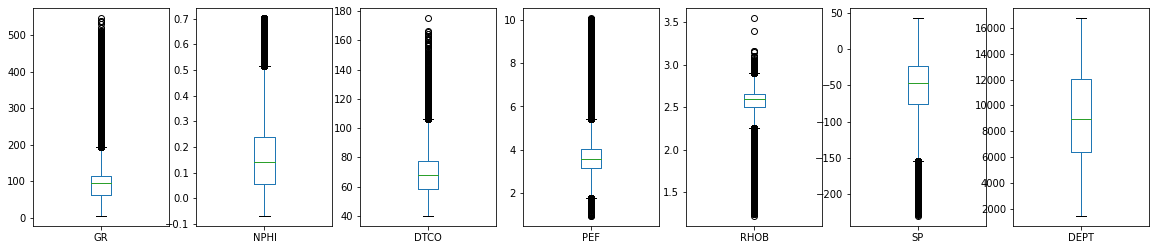

In [7]:
features = ['GR', 'NPHI', 'DTCO', 'PEF', 'RHOB', 'SP', 'DEPT']

def plot_features_box_plot(df=df, features=features):
    plt.figure(figsize=(20, 4))

    for idx, feature in enumerate(features):   
        plt.subplot(1, len(features), idx+1)
        df[feature].plot.box()
    plt.show()

plot_features_box_plot()

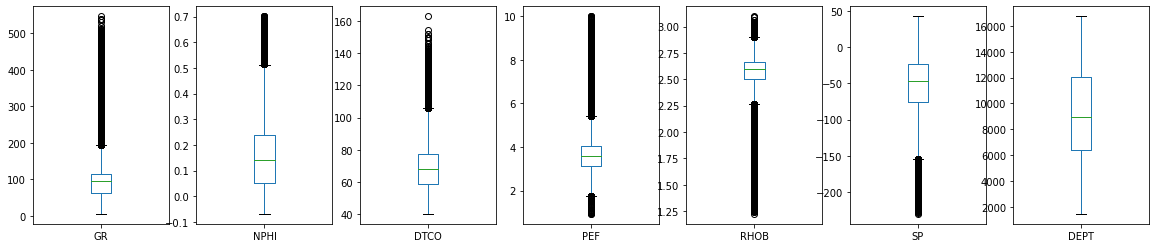

In [8]:
df = df.loc[
    (df['GR'] < 550) & 
    (df['DTCO'] < 170) & 
    (df['CAL'] >= 6) & (df['CAL'] <= 21) & 
    (df['PEF'] <= 10) &
    (df['RHOB'] <= 3.1) & 
    (df['SP'] <= 150), :]
df = df[df['DTCO'] < df['DTSM']]
plot_features_box_plot(df)

## Split Train & Test Data

In [9]:
X = df[features]
y = df['DTSM']

# Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

print('Total shape: ', df.shape)
print('Train shape: ', X_train.shape)
print('Test shape: ', X_test.shape)

Total shape:  (173880, 12)
Train shape:  (139104, 7)
Test shape:  (34776, 7)


## Model Building (XGBoost)

In [10]:
def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))

### Model All

In [11]:
model = XGBRegressor()
model.fit(X_train, y_train)

# Train performance
pred_train = model.predict(X_train)
print('RMSE train: ', rmse(y_train, pred_train))

# Test performance 
pred_test = model.predict(X_test)
print('RMSE test:', rmse(y_test, pred_test))

RMSE train:  7.539097411806665
RMSE test: 8.333483518220477


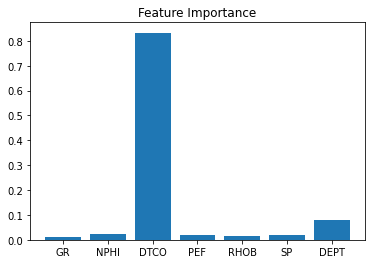

In [12]:
plt.bar(features, model.feature_importances_)
plt.title('Feature Importance')
plt.show()

### Model No PEF

In [13]:
# Split data 
X_no_pef = X.drop(columns='PEF')
X_train_no_pef, X_test_no_pef, _, _ = train_test_split(X_no_pef, y, test_size=0.2, random_state=9)

In [14]:
model_no_pef = XGBRegressor()
model_no_pef.fit(X_train_no_pef, y_train)

# Train performance
pred_train = model_no_pef.predict(X_train_no_pef)
print('RMSE train: ', rmse(y_train, pred_train))

# Test performance 
pred_test = model_no_pef.predict(X_test_no_pef)
print('RMSE test:', rmse(y_test, pred_test))

RMSE train:  7.718563099561678
RMSE test: 8.47888907316125


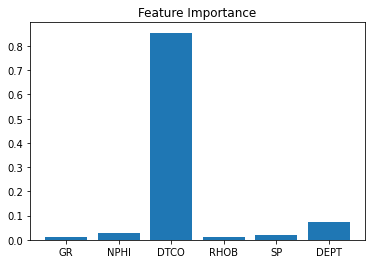

In [15]:
plt.bar([feature for feature in features if feature != 'PEF'], model_no_pef.feature_importances_)
plt.title('Feature Importance')
plt.show()

### Model No SP

In [16]:
# Split data 
X_no_sp = X.drop(columns='SP')
X_train_no_sp, X_test_no_sp, _, _ = train_test_split(X_no_sp, y, test_size=0.2, random_state=9)

In [17]:
model_no_sp = XGBRegressor()
model_no_sp.fit(X_train_no_sp, y_train)

# Train performance
pred_train_no_sp = model_no_sp.predict(X_train_no_sp)
print('RMSE train: ', rmse(y_train, pred_train_no_sp))

# Test performance 
pred_test_no_sp = model_no_sp.predict(X_test_no_sp)
print('RMSE test:', rmse(y_test, pred_test_no_sp))

RMSE train:  7.990412059613872
RMSE test: 8.804390255716322


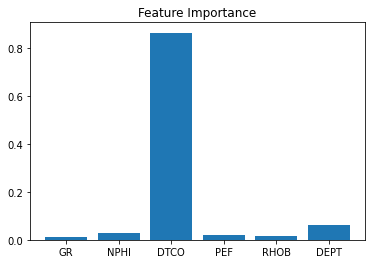

In [18]:
plt.bar([feature for feature in features if feature != 'SP'], model_no_sp.feature_importances_)
plt.title('Feature Importance')
plt.show()

### Model No SP & PEF

In [19]:
# Split data 
X_no_sp_pef = X.drop(columns=['SP', 'PEF'])
X_train_no_sp_pef, X_test_no_sp_pef, _, _ = train_test_split(X_no_sp_pef, y, test_size=0.2, random_state=9)

In [20]:
model_no_sp_pef = XGBRegressor()
model_no_sp_pef.fit(X_train_no_sp_pef, y_train)

# Train performance
pred_train_no_sp_pef = model_no_sp_pef.predict(X_train_no_sp_pef)
print('RMSE train: ', rmse(y_train, pred_train_no_sp_pef))

# Test performance 
pred_test_no_sp_pef = model_no_sp_pef.predict(X_test_no_sp_pef)
print('RMSE test:', rmse(y_test, pred_test_no_sp_pef))

RMSE train:  8.298783496357233
RMSE test: 9.0421988835626


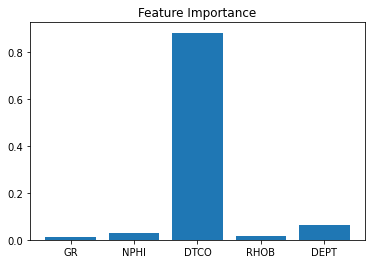

In [21]:
plt.bar([feature for feature in features if feature not in ['SP', 'PEF']], model_no_sp_pef.feature_importances_)
plt.title('Feature Importance')
plt.show()

## Prediction

In [22]:
df_test = pd.read_csv('data/preprocessed/test.csv', index_col=0)
df_test.head()

,WELL,DEPT,CAL,SP,GR,NPHI,DRES,DTCO,PEF,RHOB,DRHO
0,00d02be79f49_TGS.las,9912.0,6.2363,12.2620,49.1883,0.4860,1900.9751,NaN,NaN,1.8771,-0.2491
1,00d02be79f49_TGS.las,9912.5,6.2481,5.1245,56.5820,0.4769,1990.3184,NaN,NaN,1.8989,-0.2487
2,00d02be79f49_TGS.las,9913.0,6.2844,-4.5998,68.5213,0.4480,1988.7848,NaN,NaN,2.0063,-0.2482
3,00d02be79f49_TGS.las,9913.5,6.6677,-14.8317,78.8782,0.3845,1987.2515,NaN,NaN,2.0603,-0.2478
4,00d02be79f49_TGS.las,9914.0,7.2943,-17.6811,83.4741,0.3215,1985.7203,NaN,NaN,2.1871,-0.2474


In [23]:
model_all_test_wells = ['2f96a5f92418_TGS', '34a80ab7a5fa_TGS', '1684cc35f399_TGS', '7595ba9fb314_TGS', 
                        '63250f7d463b_TGS', '113412eec2a6_TGS', '302460e3021a_TGS', '20372701d5e2_TGS', 
                        'ed48bda2217f_TGS', 'eed1e9537976_TGS', 'fca03aa6acde_TGS', 'ff7845ea074d_TGS']
model_no_pef_test_wells = ['00d02be79f49_TGS', '84c5fb9cc880_TGS']
model_no_sp_test_wells = ['0a7822c59487_TGS', '8e37531ba266_TGS', '94c1f5cae85c_TGS', '638f2cc65681_TGS', '3369b6f8fb6f_TGS']
model_no_sp_pef_test_wells = ['ae16a9f64878_TGS']

model_test_wells = {
    model: {
        'features': list(X_train.columns), 
        'wells': model_all_test_wells
    }, 
    model_no_pef: {
        'features': list(X_train_no_pef.columns), 
        'wells': model_no_pef_test_wells
    },
    model_no_sp: {
        'features': list(X_train_no_sp.columns), 
        'wells': model_no_sp_test_wells
    },
    model_no_sp_pef: {
        'features': list(X_train_no_sp_pef.columns), 
        'wells': model_no_sp_pef_test_wells
    }
}

In [24]:
for model_test, test_wells in model_test_wells.items():
    test_well_features = test_wells['features']
    for test_well in test_wells['wells']:
        well_code = test_well + '.las'
        model_test_pred = model_test.predict(df_test.loc[df_test['WELL'] == well_code, test_well_features])
        df_test.loc[df_test['WELL'] == well_code, 'DTSM_PRED'] = model_test_pred

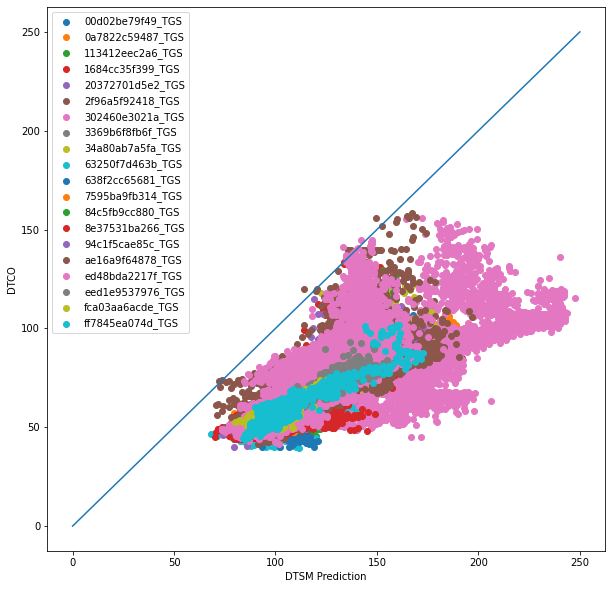

In [25]:
plt.figure(figsize=(10, 10))
for well in df_test['WELL'].unique():
    plt.scatter(df_test.loc[df_test['WELL'] == well, 'DTSM_PRED'], 
                df_test.loc[df_test['WELL'] == well, 'DTCO'], label=well[:-4])
plt.plot(np.linspace(0,250,11), np.linspace(0,250,11))
plt.xlabel('DTSM Prediction')
plt.ylabel('DTCO')
plt.legend()
plt.show()

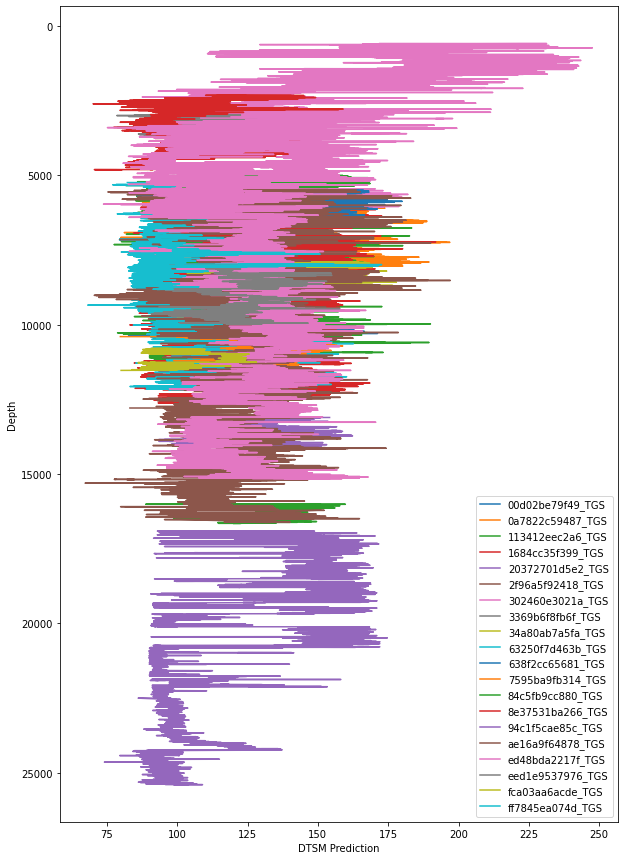

In [26]:
plt.figure(figsize=(10, 15))
for well in df_test['WELL'].unique():
    plt.plot(df_test.loc[df_test['WELL'] == well, 'DTSM_PRED'], 
                df_test.loc[df_test['WELL'] == well, 'DEPT'], label=well[:-4])
plt.xlabel('DTSM Prediction')
plt.ylabel('Depth')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

## Submission

In [27]:
# Export prediction outputs to Excel files
for well in df_test['WELL'].unique():
    submission = df_test.loc[df_test['WELL'] == well, ['DEPT', 'DTSM_PRED']]
    submission.columns = ['Depth', 'DTSM']
    submission.to_excel('submission/' + well[:-4] + '.xlsx', index=False)

In [28]:
# Compress to zip 
with zipfile.ZipFile('submission/DoaIbu.zip', 'w') as zipF:
    for file in os.listdir('submission'):
        if file.endswith('.xlsx'):
            zipF.write(os.getcwd() + '/submission/' + file, file)